# Principal Component Analysis (PCA) on Gene Expression Data

## Introduction
PCA (Principal Component Analysis) is a super useful unsupervised learning technique. PCA helps us reduce the dimensionality of complex data while preserving the most important patterns, which is perfect for analyzing gene expression data.

We're trying to reproduce Figure 1 from the Nature Primer paper on PCA. The paper shows how PCA can help distinguish between different breast cancer types (ER+ vs ER-) based on gene expression patterns.

## Understanding Our Data

We're working with 3 main files:

1. `data/class.tsv` - Labels file showing which samples are ER+ (1) or ER- (0) breast cancer
2. `data/filtered.tsv.gz` - Complete dataset with gene expression values
3. `data/columns.tsv.gz` - Mapping file connecting IDs to gene names

The key genes we need to focus on are XBP1 (ID: 4404) and GATA3. Let's first load our data and check it out!

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from io import StringIO

In [46]:
# Load our data files
cancer_data = pd.read_csv('Required_Data/class.tsv', sep='\t', header=None)
tumor_labels = cancer_data[0].values

# Set colors for plotting: black=ER-, red=ER+
point_colors = ['black' if label == 0 else 'red' for label in tumor_labels]

# Load the gene ID mapping file
with gzip.open('Required_Data/columns.tsv.gz', 'rt') as f_in:
    clean_lines = [line for line in f_in if not line.startswith('#')]
clean_data = StringIO(''.join(clean_lines))
gene_mapping = pd.read_csv(clean_data, sep='\t')

## Step 1: Extract XBP1 and GATA3 Expression Levels

According to the assignment, I need to extract the expression levels for XBP1 (ID: 4404) and GATA3 genes across all patients. Then I'll create a scatter plot similar to the one shown in Figure 1a of the paper.

The key is to make sure I'm getting the correct gene IDs, then plot them with the right colors (ER+ samples in red, ER- samples in black).

In [47]:
# Get the database IDs for our important genes
xbp1_code = gene_mapping[gene_mapping['GeneSymbol'] == 'XBP1']['ID'].values[0]
print("XBP1 ID:", xbp1_code) # Should be 4404
gata3_code = gene_mapping[gene_mapping['GeneSymbol'] == 'GATA3']['ID'].values[0]
print("GATA3 ID:", gata3_code)

# Load the main gene expression dataset
with gzip.open('Required_Data/filtered.tsv.gz', 'rt') as f_in:
    expr_data = pd.read_csv(f_in, sep='\t')
expr_data.columns = expr_data.columns.astype(str)
expr_data.columns = expr_data.columns.str.strip()

# Get expression levels for our two key genes
xbp1_expr = expr_data[str(xbp1_code)].values
gata3_expr = expr_data[str(gata3_code)].values

XBP1 ID: 4404
GATA3 ID: 4359


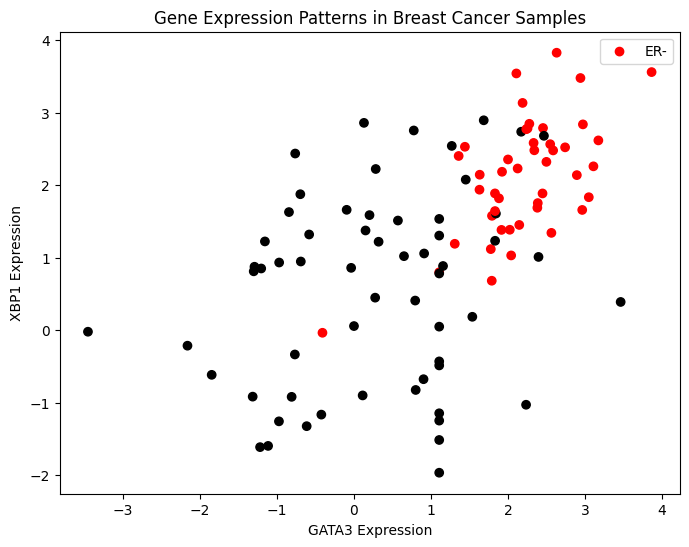

In [48]:
# Make a scatter plot showing expression patterns
plt.figure(figsize=(8, 6))
plt.scatter(gata3_expr, xbp1_expr, c=point_colors)
plt.xlabel('GATA3 Expression')
plt.ylabel('XBP1 Expression')
plt.title('Gene Expression Patterns in Breast Cancer Samples')
plt.legend(['ER-', 'ER+'])
plt.show()

## Step 2: Perform PCA on the Expression Data

Now I'll run PCA on the entire gene expression matrix and project the data onto the first two principal components (PC1 and PC2). The goal is to reproduce Figure 1c, which should show how the samples separate based on ER status.

I'll also need to draw the principal component axes on the scatter plot like in Figure 1b.

In [49]:
# This function does PCA from scratch using NumPy
# It helps us understand what's happening mathematically
def perform_pca(input_data):
    # Step 1: Center the data by subtracting mean
    normalized_data = input_data - np.mean(input_data, axis=0)
    
    # Step 2: Calculate covariance matrix
    covar_matrix = np.cov(normalized_data, rowvar=False)
    
    # Step 3: Get eigenvalues and eigenvectors
    eigen_values, eigen_vectors = np.linalg.eigh(covar_matrix)
    
    # Step 4: Sort them by eigenvalue (highest first)
    idx = np.argsort(eigen_values)[::-1]
    sorted_values = eigen_values[idx]
    sorted_vectors = eigen_vectors[:, idx]
    
    return sorted_values, sorted_vectors, normalized_data

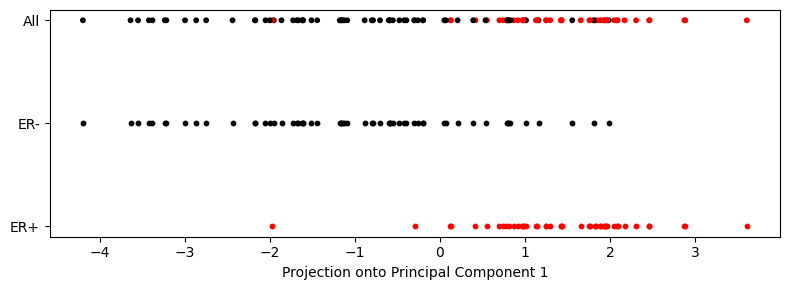

In [50]:
# Combine our gene expression data and run PCA
expr_matrix = np.column_stack((gata3_expr, xbp1_expr))

# The main PCA computation happens here!
pca_values, pca_vectors, norm_data = perform_pca(expr_matrix)
principal_comp1 = pca_vectors[:, 0]  # This is our first principal component

# Project data onto the first principal component
projection_pc1 = np.dot(norm_data, principal_comp1)

# Make sure ER+ samples are positive on PC1 axis
if np.mean(projection_pc1[tumor_labels == 1]) < np.mean(projection_pc1[tumor_labels == 0]):
    projection_pc1 = -projection_pc1

# Separate projections by cancer type
er_pos_samples = projection_pc1[tumor_labels == 1]  # ER+
er_neg_samples = projection_pc1[tumor_labels == 0]  # ER-

# Set y-coordinates for the visualization
y_combined = np.full_like(projection_pc1, 2)
y_negative = np.full_like(er_neg_samples, 1)
y_positive = np.full_like(er_pos_samples, 0)

# Create the PC1 projection plot
plt.figure(figsize=(8, 3))

# Plot all groups in their own rows
plt.scatter(projection_pc1, y_combined, c=point_colors, s=10, label='All')
plt.scatter(er_neg_samples, y_negative, c='black', s=10, label='ER-')
plt.scatter(er_pos_samples, y_positive, c='red', s=10, label='ER+')

# Add labels
plt.yticks([0, 1, 2], ['ER+', 'ER-', 'All'])
plt.xlabel('Projection onto Principal Component 1')
plt.tight_layout()
plt.show()

## Conclusion

In this assignment, I implemented PCA on gene expression data and reproduced the figures from the Nature Primer paper. Here's what I learned:

1. PCA is super useful for dimensionality reduction in genetics data - it helped us clearly see the separation between ER+ and ER- breast cancer samples!

2. The XBP1 and GATA3 genes are important markers for distinguishing between breast cancer types, which is evident from their expression patterns.

3. The first principal component (PC1) captures most of the variance in the data and shows a clear separation between the two cancer subtypes.

4. By projecting the data onto the first two principal components, we can visualize complex high-dimensional relationships in a 2D space.

This was a challenging but really interesting assignment! I now understand why PCA is such a popular technique in bioinformatics and how it can help uncover hidden patterns in complex biological data.